# Feature Selection in Data Science: A Hybrid Approach

In [1]:
import numpy as np
import pandas as pd
import time
import warnings
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import networkx as nx

from scipy import stats
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks
from scipy.cluster import hierarchy

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.datasets import load_wine, fetch_california_housing, load_breast_cancer, load_diabetes, make_regression
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as patches

warnings.filterwarnings('ignore')


## Feature Selector Implementation

In [2]:


class FeatureSelector(BaseEstimator, TransformerMixin):
    """
    A hybrid feature selection method combining tree-based feature importance and clustering.
    """
    
    def __init__(self, task_type='classification', n_clusters=None, importance_threshold=0.01):
        self.task_type = task_type
        self.n_clusters = n_clusters
        self.importance_threshold = importance_threshold
        
        # Initialize the appropriate RandomForest model
        if self.task_type == 'classification':
            self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        else:
            self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        
        self.selected_features_ = None
        self.feature_importance_ = None
    
    def fit(self, X, y, min_threshold=0.5, max_threshold=0.95):

    # Compute feature importances
        self.model.fit(X, y)
        importance = self.model.feature_importances_
        self.feature_importance_ = pd.Series(importance, index=X.columns)
    
    # Select features above the importance threshold
        important_features = self.feature_importance_[self.feature_importance_ > self.importance_threshold]
    
    # If no important features, return empty selection
        if len(important_features) == 0:
            self.selected_features_ = []
            self.feature_clusters_ = pd.Series()
            return self
    
    # Compute correlation matrix for important features
        corr_matrix = X[important_features.index].corr().abs()
    
    # Get upper triangle of correlation matrix (excluding diagonal)
        corr_values = []
        for i in range(len(corr_matrix.columns)):
            for j in range(i+1, len(corr_matrix.columns)):
                corr_values.append(corr_matrix.iloc[i, j])
    
    # Sort correlation values
        corr_values = sorted(corr_values)
    
    # Determine the adaptive threshold using multiple methods
        thresholds = []
    
    # Method 1: Gap statistic - find the largest gap
        if len(corr_values) > 1:
            gaps = [corr_values[i+1] - corr_values[i] for i in range(len(corr_values)-1)]
            max_gap_idx = np.argmax(gaps)
        # Only consider gaps in high correlation range (above 0.5)
            if corr_values[max_gap_idx] >= min_threshold:
                gap_threshold = (corr_values[max_gap_idx] + corr_values[max_gap_idx+1]) / 2
                thresholds.append(gap_threshold)
    
    # Method 2: Elbow method - find point of maximum curvature
        if len(corr_values) > 2:
        # Calculate curvature (approximate second derivative)
            curvature = []
            for i in range(1, len(corr_values)-1):
                y1, y2, y3 = corr_values[i-1], corr_values[i], corr_values[i+1]
                curvature.append(y1 + y3 - 2*y2)
        
        # Find maximum curvature point
            if curvature:
                max_curve_idx = np.argmax(curvature) + 1  # +1 because we start at index 1
                if corr_values[max_curve_idx] >= min_threshold:
                    elbow_threshold = corr_values[max_curve_idx]
                    thresholds.append(elbow_threshold)
    
    # Method 3: Use KDE to find the valley in distribution
        if len(corr_values) > 10:  # Need enough points for KDE
            try:

            
            # Only consider higher correlations for density estimation
                high_corrs = [c for c in corr_values if c >= min_threshold]
                if len(high_corrs) > 5:  # Need enough points
                    kde = gaussian_kde(high_corrs)
                    x = np.linspace(min_threshold, max_threshold, 100)
                    y = kde(x)
                
                # Find peaks (maxima)
                    peaks, _ = find_peaks(y)
                
                # Find valleys (minima)
                    valleys, _ = find_peaks(-y)
                
                    if len(valleys) > 0:
                    # Choose the most significant valley
                        valley_depths = [min(y[peaks[i]], y[peaks[i+1]]) - y[valleys[i]] 
                                        for i in range(len(valleys)) 
                                        if i < len(peaks)-1 and valleys[i] > peaks[i] and valleys[i] < peaks[i+1]]
                    
                        if valley_depths:
                            best_valley_idx = np.argmax(valley_depths)
                            kde_threshold = x[valleys[best_valley_idx]]
                            thresholds.append(kde_threshold)
            except (ImportError, ValueError) as e:
            # Skip this method if there's an error
                pass
    
    # Select final threshold
        if thresholds:
        # If multiple thresholds found, take the average
            adaptive_threshold = sum(thresholds) / len(thresholds)
        # Keep it within reasonable bounds
            adaptive_threshold = max(min(adaptive_threshold, max_threshold), min_threshold)
        else:
        # Fallback to a default if no threshold found
            adaptive_threshold = 0.85
    
        print(f"Adaptive correlation threshold: {adaptive_threshold:.4f}")
        self.correlation_threshold_ = adaptive_threshold
    
    # Helper function to create connected components based on high correlations
        def find_correlation_groups(corr_matrix, threshold):
        # Initialize each feature in its own group
            n_features = corr_matrix.shape[0]
            feature_names = corr_matrix.index
        
        # Use Union-Find data structure for efficient connected components
            parent = list(range(n_features))
        
            def find(x):
                if parent[x] != x:
                    parent[x] = find(parent[x])
                return parent[x]
        
            def union(x, y):
                parent[find(x)] = find(y)
        
        # For each pair of highly correlated features, merge their groups
            for i in range(n_features):
                for j in range(i+1, n_features):
                    if corr_matrix.iloc[i, j] >= threshold:
                        union(i, j)
        
        # Collect final groups
            groups = {}
            for i in range(n_features):
                root = find(i)
                if root not in groups:
                    groups[root] = []
                groups[root].append(feature_names[i])
        
            return list(groups.values())
    
    # Find correlation groups using the adaptive threshold
        correlation_groups = find_correlation_groups(corr_matrix, adaptive_threshold)
    
    # Rest of your existing code to handle the groups
    # Create cluster assignments
        cluster_id = 0
        feature_clusters = {}
        for group in correlation_groups:
            for feature in group:
                feature_clusters[feature] = cluster_id
            cluster_id += 1
    
    # Convert to Series for easier handling
        self.feature_clusters_ = pd.Series(feature_clusters)
    
    # Select highest importance feature from each group
        selected_features = []
        for group in correlation_groups:
            best_feature = important_features[group].idxmax()
            selected_features.append(best_feature)
    
    # simply take the top n_clusters by importance
        if self.n_clusters is not None and len(selected_features) > self.n_clusters:
        # Sort by importance and take top n_clusters
            selected_features = [f for f in important_features.sort_values(ascending=False).index 
                                if f in selected_features][:self.n_clusters]
    
        self.selected_features_ = selected_features
        return self
    
    def transform(self, X):
        """
        Transform X to retain only the selected features.
        """
        if self.selected_features_ is None:
            raise ValueError("Call 'fit' before calling transform.")
        return X[self.selected_features_]
    
    def fit_transform(self, X, y):
        """
        Fit to the data, then transform it.
        """
        return self.fit(X, y).transform(X)


## Evaluation Functions

In [3]:

def evaluate_method(X, y, method, task_type='classification'):
    """Evaluate a feature selection method."""
    # Time the selection process
    start_time = time.time()
    
    # Handle PCA separately since it doesn't need y for fit
    if isinstance(method, PCA):
        X_selected = method.fit_transform(X)
    else:
        # For other methods, use fit_transform with both X and y
        X_selected = method.fit_transform(X, y)
    
    selection_time = time.time() - start_time
    
    # Create appropriate model and scorer based on task type
    if task_type == 'classification':
        model = RandomForestClassifier(random_state=42)
        scorer = make_scorer(accuracy_score)
    else:
        model = RandomForestRegressor(random_state=42)
        scorer = make_scorer(r2_score)
    
    # Calculate cross-validation scores
    scores = cross_val_score(model, X_selected, y, scoring=scorer, cv=5)
    
    return {
        'mean_score': scores.mean(),
        'std_score': scores.std(),
        'selection_time': selection_time,
        'n_features': X_selected.shape[1]
    }

def compare_methods(X, y, task_type='classification', importance_threshold=0.01, pca_variance=0.95):
    """Compare different feature selection methods with automatic feature number selection."""
    # Create base estimator based on task type
    if task_type == 'classification':
        base_estimator = RandomForestClassifier(random_state=42)
    else:
        base_estimator = RandomForestRegressor(random_state=42)
    
    # Initialize methods:
    # For our method, if n_clusters is None, it returns all features above threshold.
    custom_method = FeatureSelector(task_type=task_type, n_clusters=None, 
                                    importance_threshold=importance_threshold)
    
    # Use RFECV for RFE so it selects the optimal number of features automatically.
    from sklearn.feature_selection import RFECV
    rfe_method = RFECV(estimator=base_estimator, cv=5)
    
    # For PCA, use a variance threshold (e.g., 95%) so that PCA determines the number of components.
    pca_method = PCA(n_components=pca_variance)
    
    methods = {
        'Our Method': custom_method,
        'RFE' : rfe_method,
        'PCA': pca_method
    }
    
    # Evaluate each method
    results = {}
    for name, method in methods.items():
        results[name] = evaluate_method(X, y, method, task_type)
    
    return results

def plot_comparison(results, title):
    """Create comparison plots."""
    metrics = ['mean_score', 'n_features', 'selection_time']
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    for i, metric in enumerate(metrics):
        data = [results[method][metric] for method in results.keys()]
        axes[i].bar(results.keys(), data)
        axes[i].set_title(f'{metric.replace("_", " ").title()}')
        axes[i].tick_params(axis='x', rotation=45)
        
        # Add value labels on bars
        for j, v in enumerate(data):
            axes[i].text(j, v, f'{v:.3f}', ha='center', va='bottom')
    
    plt.suptitle(title, y=1.05)
    plt.tight_layout()
    plt.show()
def visualize_feature_clusters_enhanced(selector, X, threshold=0.1, figsize=(20, 15), focus_on_selected=True, max_features=30):
    if not hasattr(selector, 'feature_clusters_'):
        print("Selector needs to be fitted first.")
        return
    
    # Get feature importances and cluster assignments
    importances = selector.feature_importance_
    clusters = selector.feature_clusters_
    selected_features = selector.selected_features_
    
    # Get correlation matrix
    corr_matrix = X[clusters.index].corr().abs()
    
    # Create a figure with 2x2 subplots
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(2, 2)
    
    # Add a text box showing all selected features
    ax_text = fig.add_axes([0.01, 0.01, 0.98, 0.05])
    ax_text.axis('off')
    selected_text = "Selected Features: " + ", ".join(selected_features)
    ax_text.text(0.5, 0.5, selected_text, ha='center', va='center', fontsize=12, 
                wrap=True, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="red", alpha=0.9))
    
    # Assign unique colors to each cluster
    n_clusters = len(clusters.unique())
    cluster_colors = plt.cm.tab20(np.linspace(0, 1, n_clusters))
    cluster_color_map = {cluster_id: cluster_colors[i] for i, cluster_id in enumerate(sorted(clusters.unique()))}
    
    # Determine which features to display if we need to limit
    if focus_on_selected and len(clusters) > max_features:
        # Always include selected features
        features_to_show = set(selected_features)
        
        # Add highly correlated features to selected features
        for selected in selected_features:
            # Get correlations with selected feature
            corrs = corr_matrix[selected].sort_values(ascending=False)
            # Add top correlated features (excluding self)
            for feat, corr_val in corrs.iloc[1:4].items():  # Take top 3 correlated features
                if corr_val > threshold * 0.7:  # Slightly lower threshold for visibility
                    features_to_show.add(feat)
        
        # Convert to list and ensure we don't exceed max_features
        features_to_show = list(features_to_show)
        if len(features_to_show) > max_features:
            features_to_show = selected_features + [f for f in features_to_show if f not in selected_features][:max_features-len(selected_features)]
        
        # Filter importances, clusters and correlation matrix
        filtered_importances = importances[features_to_show]
        filtered_clusters = clusters[features_to_show]
        filtered_corr_matrix = corr_matrix.loc[features_to_show, features_to_show]
    else:
        filtered_importances = importances
        filtered_clusters = clusters
        filtered_corr_matrix = corr_matrix
        features_to_show = filtered_clusters.index.tolist()
    
    # 1. Enhanced Correlation Heatmap with Cluster Boundaries
    ax1 = fig.add_subplot(gs[0, 0])
    
    # Order features by cluster for better visualization
    cluster_ordered_features = []
    for cluster_id in sorted(filtered_clusters.unique()):
        cluster_features = filtered_clusters[filtered_clusters == cluster_id].index.tolist()
        # Sort features within cluster by importance
        sorted_features = sorted(cluster_features, key=lambda x: filtered_importances[x], reverse=True)
        cluster_ordered_features.extend(sorted_features)
    
    ordered_corr = filtered_corr_matrix.loc[cluster_ordered_features, cluster_ordered_features]
    
    # Plot heatmap
    sns.heatmap(ordered_corr, ax=ax1, cmap="YlGnBu", 
                linewidths=0.01, vmin=0, vmax=1, 
                cbar_kws={"shrink": .8, "label": "Correlation"})
    
    # Add cluster boundaries
    current_idx = 0
    for cluster_id in sorted(filtered_clusters.unique()):
        cluster_size = sum(filtered_clusters == cluster_id)
        if cluster_size > 0:
            # Draw a rectangle around the cluster
            rect = patches.Rectangle(
                (current_idx, current_idx), 
                cluster_size, cluster_size,
                linewidth=2, 
                edgecolor=matplotlib.colors.to_hex(cluster_color_map[cluster_id]),
                facecolor='none'
            )
            ax1.add_patch(rect)
            
            # Highlight selected feature with a star
            for i, feature in enumerate(cluster_ordered_features[current_idx:current_idx+cluster_size]):
                if feature in selected_features:
                    ax1.plot(current_idx + i + 0.5, current_idx + i + 0.5, 'w*', markersize=10)
            
            current_idx += cluster_size
    
    ax1.set_title('Correlation Heatmap with Cluster Boundaries', fontsize=14)
    
    # Make tick labels readable
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90, fontsize=8)
    ax1.set_yticklabels(ax1.get_yticklabels(), fontsize=8)
    
    # 2. Network Graph of Feature Relationships
    ax2 = fig.add_subplot(gs[0, 1])
    
    # Create network graph
    G = nx.Graph()
    
    # Add nodes with properties
    for feature in features_to_show:
        G.add_node(
            feature, 
            importance=filtered_importances[feature],
            cluster=filtered_clusters[feature],
            selected=(feature in selected_features)
        )
    
    # Add edges for correlations above threshold
    for i, feat1 in enumerate(filtered_corr_matrix.columns):
        for j, feat2 in enumerate(filtered_corr_matrix.columns):
            if i < j and filtered_corr_matrix.loc[feat1, feat2] >= threshold:
                G.add_edge(
                    feat1, feat2, 
                    weight=filtered_corr_matrix.loc[feat1, feat2]
                )
    
    # Set node colors by cluster
    node_colors = [cluster_color_map[filtered_clusters[node]] for node in G.nodes()]
    
    # Set node sizes by importance (scale for better visualization)
    importance_values = np.array([filtered_importances[node] for node in G.nodes()])
    node_sizes = 300 + 2000 * (importance_values / importance_values.max())
    
    # Get selected node indices for highlighting
    selected_indices = [i for i, node in enumerate(G.nodes()) if node in selected_features]
    
    # Create position layout - using a different algorithm for better separation
    pos = nx.kamada_kawai_layout(G) if len(G.nodes()) < 50 else nx.spring_layout(G, seed=42)
    
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_sizes, alpha=0.8, ax=ax2)
    
    # Highlight selected nodes with a border
    selected_nodes = [list(G.nodes())[i] for i in selected_indices]
    nx.draw_networkx_nodes(G, pos, nodelist=selected_nodes, node_color='none', 
                          node_size=node_sizes[selected_indices]+100, 
                          linewidths=2, edgecolors='r', ax=ax2)
    
    # Draw edges with varying width based on correlation strength
    for u, v, data in G.edges(data=True):
        width = 3 * data['weight']
        nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=width, alpha=0.5, ax=ax2)
    
    # Draw labels for all nodes with adjusted font sizes
    node_labels = {}
    for node in G.nodes():
        if node in selected_features:
            # Bigger font for selected features
            node_labels[node] = node
        elif len(G.nodes()) < 20:
            # Show all labels if we have fewer nodes
            node_labels[node] = node
        else:
            # Otherwise, leave non-selected nodes unlabeled
            node_labels[node] = ""
            
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_color='black', ax=ax2)
    
    # Add red circles around selected features for visibility
    for node in selected_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_color='none', 
                              node_size=node_sizes[list(G.nodes()).index(node)]+200, 
                              linewidths=2, edgecolors='r', ax=ax2)
    
    ax2.set_title('Feature Correlation Network\n(Node size = importance, Color = cluster)', fontsize=14)
    ax2.axis('off')
    
    # 3. Feature Importance by Cluster
    ax3 = fig.add_subplot(gs[1, 0])
    
    # Group features by cluster
    grouped_features = {}
    for cluster_id in sorted(filtered_clusters.unique()):
        cluster_features = filtered_clusters[filtered_clusters == cluster_id].index.tolist()
        grouped_features[cluster_id] = cluster_features
    
    # Prepare data for grouped bar chart
    cluster_ids = []
    feature_names = []
    importance_values = []
    is_selected = []
    
    for cluster_id, features in grouped_features.items():
        # Sort features by importance within each cluster
        sorted_features = sorted(features, key=lambda x: filtered_importances[x], reverse=True)
        
        for feature in sorted_features:
            cluster_ids.append(cluster_id)
            feature_names.append(feature)
            importance_values.append(filtered_importances[feature])
            is_selected.append(feature in selected_features)
    
    # Create a DataFrame for easier plotting
    plot_df = pd.DataFrame({
        'Cluster': cluster_ids,
        'Feature': feature_names,
        'Importance': importance_values,
        'Selected': is_selected
    })
    
    # Create a categorical color palette
    palette = {i: cluster_color_map[i] for i in sorted(filtered_clusters.unique())}
    
    # Plot grouped bar chart
    bars = sns.barplot(x='Feature', y='Importance', hue='Cluster', data=plot_df, 
                     palette=palette, dodge=False, ax=ax3)
    
    # Highlight selected features
    for i, (_, row) in enumerate(plot_df.iterrows()):
        if row['Selected']:
            bars.patches[i].set_edgecolor('red')
            bars.patches[i].set_linewidth(2)
    
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=90, ha='center', fontsize=8)
    ax3.set_title('Feature Importance by Cluster', fontsize=14)
    ax3.set_xlabel('')
    ax3.legend(title='Cluster')
    
    # 4. Hierarchical Clustering Dendrogram
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Calculate distance matrix from correlation matrix
    distance_matrix = 1 - filtered_corr_matrix
    
    # Perform hierarchical clustering
    Z = hierarchy.linkage(hierarchy.distance.squareform(distance_matrix), method='average')
    
    # Create a color map for clusters
    cluster_color_list = []
    for feature in filtered_corr_matrix.index:
        cluster_id = filtered_clusters[feature]
        cluster_color_list.append(matplotlib.colors.to_hex(cluster_color_map[cluster_id]))
    
    # Plot dendrogram
    hierarchy.dendrogram(
        Z,
        ax=ax4,
        labels=filtered_corr_matrix.index,
        orientation='right',
        leaf_font_size=9,
        link_color_func=lambda k: 'gray',
        color_threshold=0.7 * max(Z[:, 2])  # Adjust threshold for coloring
    )
    
    # Color the labels based on cluster
    for i, label in enumerate(ax4.get_ymajorticklabels()):
        feature = label.get_text()
        cluster_id = filtered_clusters[feature]
        label.set_color(matplotlib.colors.to_hex(cluster_color_map[cluster_id]))
        
        # Mark selected features
        if feature in selected_features:
            label.set_fontweight('bold')
            label.set_bbox(dict(facecolor='white', edgecolor='red', alpha=0.7, boxstyle='round,pad=0.2'))
    
    ax4.set_title('Hierarchical Clustering of Features', fontsize=14)
    
    # Add title to the figure
    plt.suptitle('Feature Cluster Analysis', fontsize=20, y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    
    return fig

## Run Experiments


Wine Dataset Results:
Adaptive correlation threshold: 0.7436

Detailed Results:
                Our Method      RFE     PCA
mean_score          0.9721   0.9721  0.7079
std_score           0.0248   0.0176  0.0418
selection_time      0.1391   9.3658  0.0022
n_features         10.0000  13.0000  1.0000


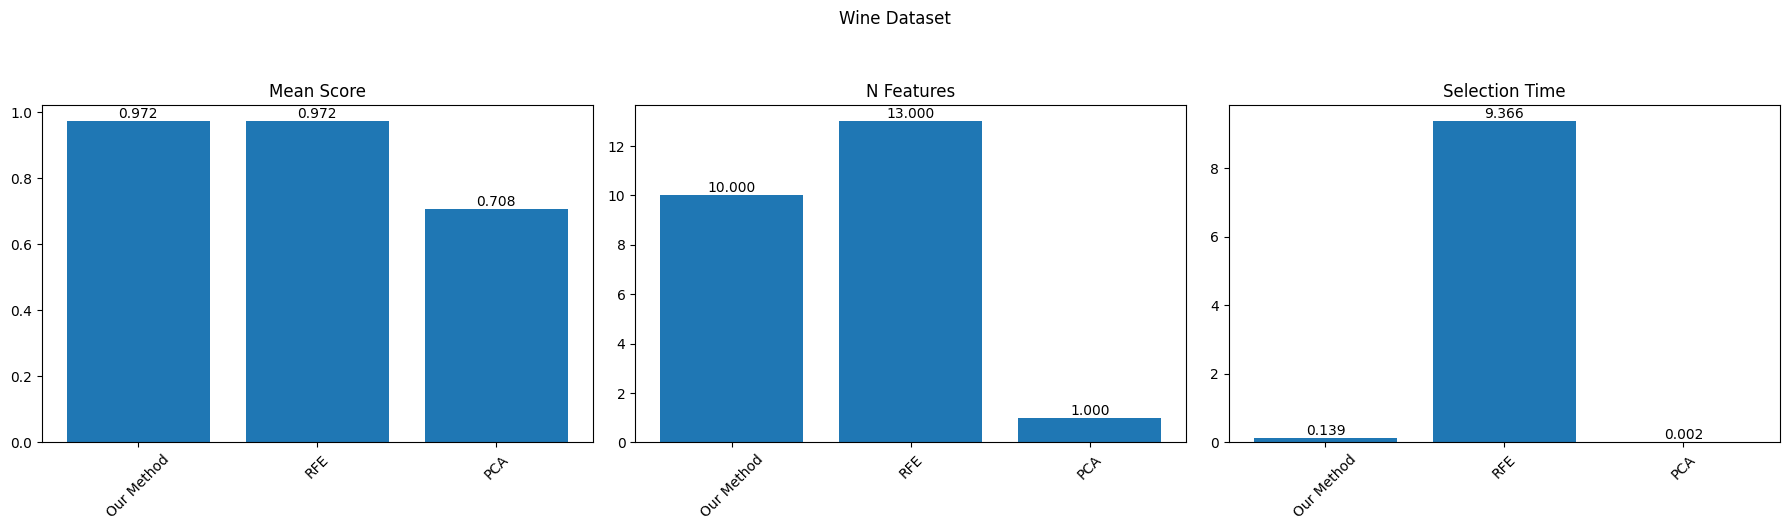


Generating Enhanced Visualizations...
Adaptive correlation threshold: 0.7436


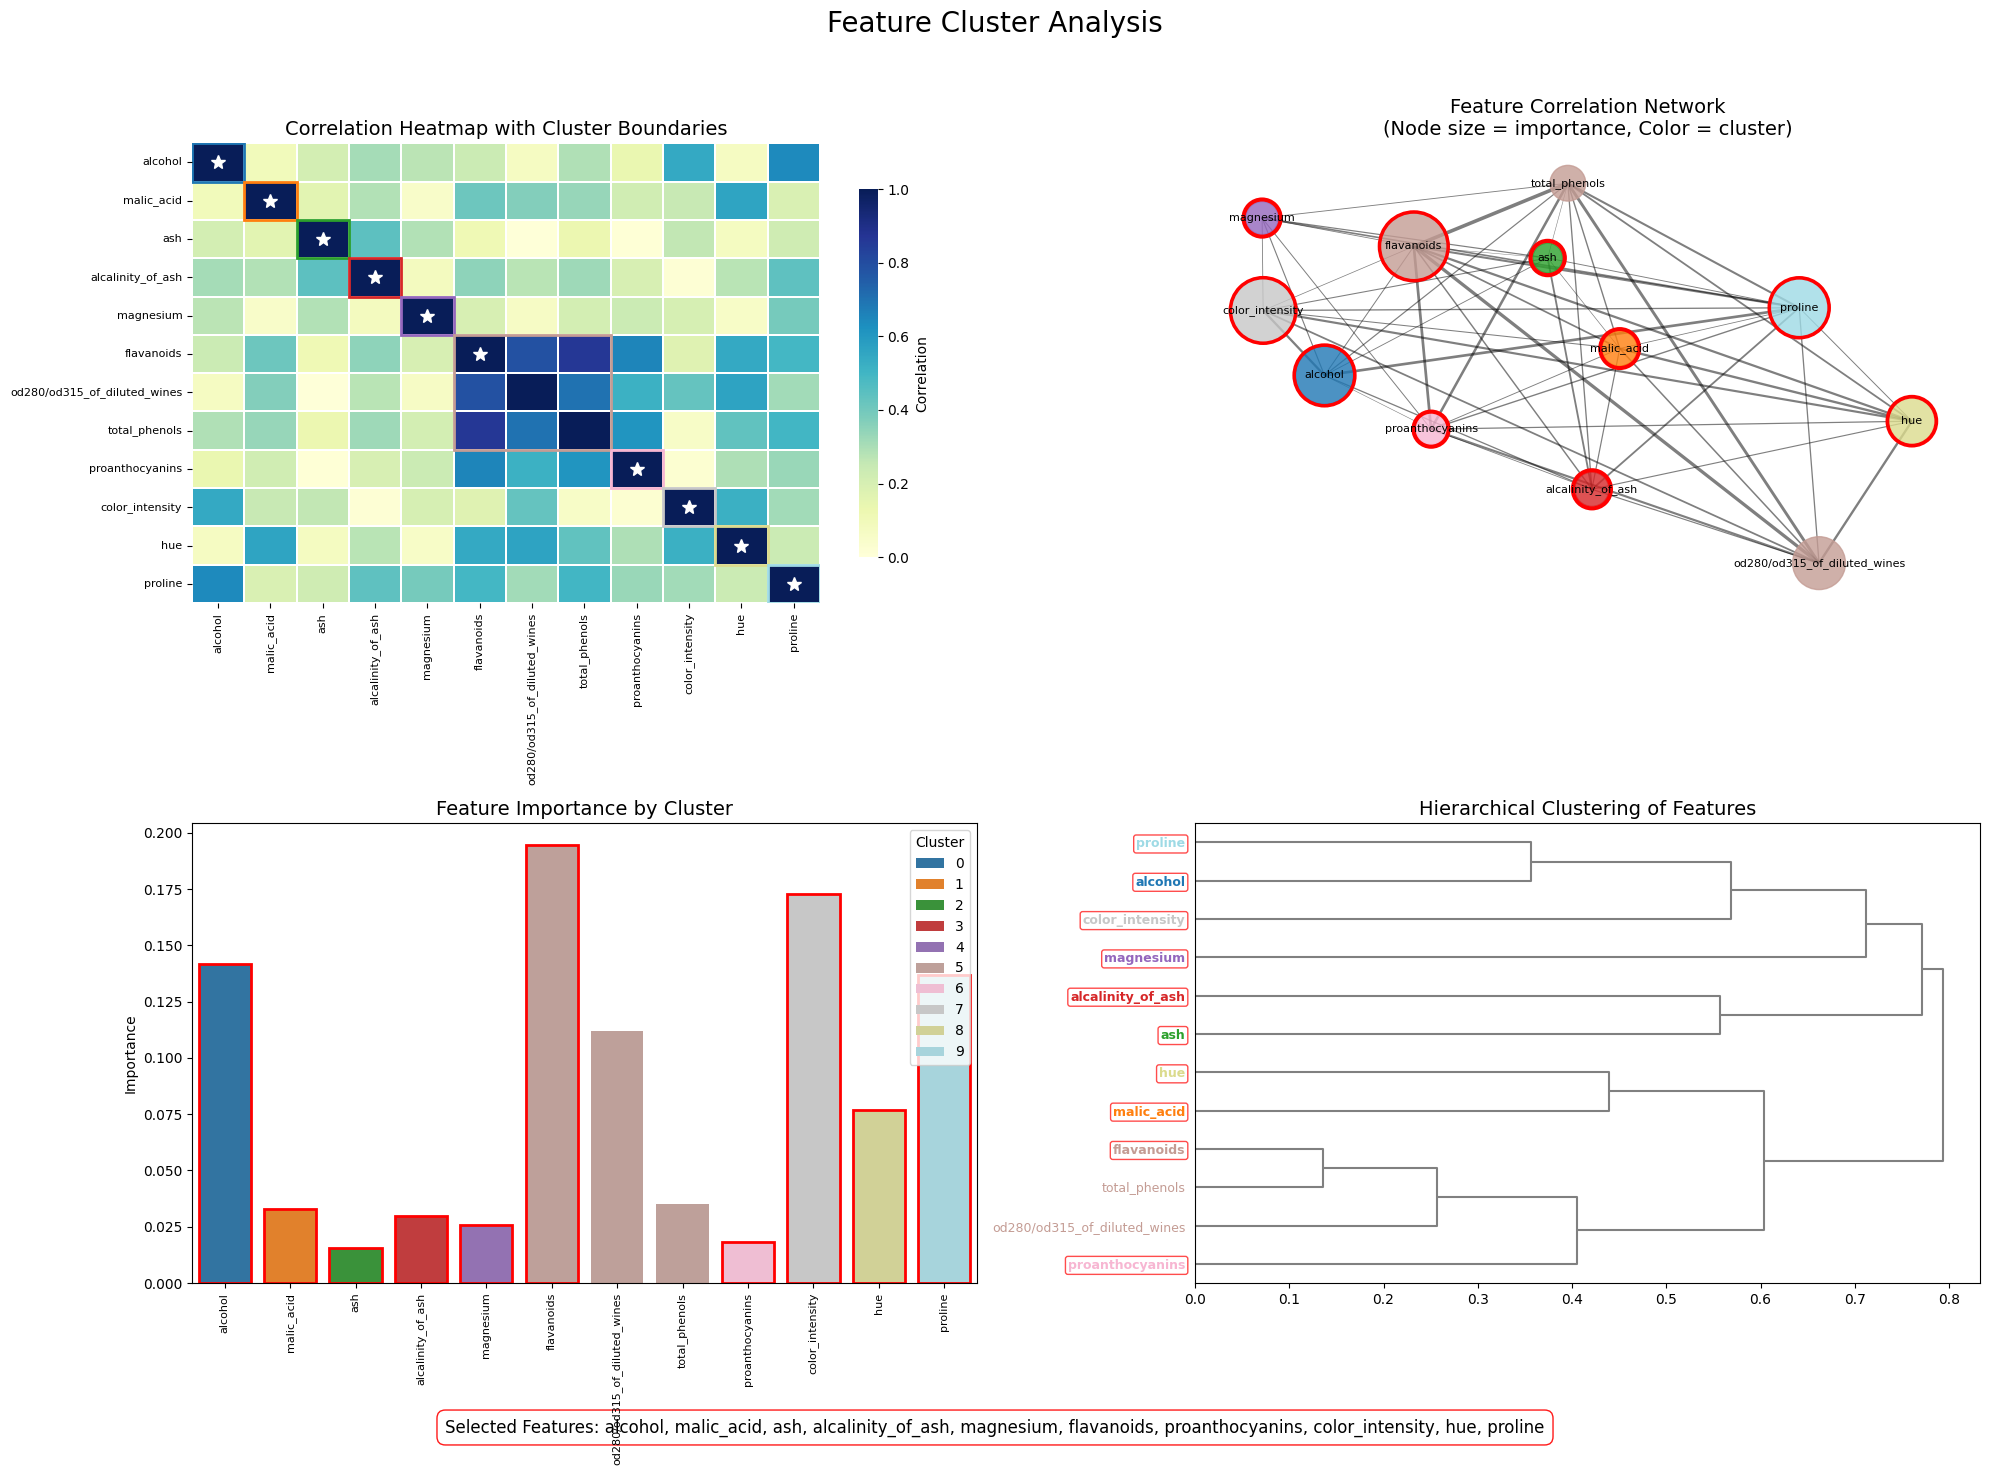


BreastCancer Dataset Results:
Adaptive correlation threshold: 0.9091

Detailed Results:
                Our Method      RFE     PCA
mean_score          0.9578   0.9666  0.8489
std_score           0.0225   0.0195  0.0207
selection_time      0.2594  29.7599  0.0040
n_features          8.0000  16.0000  1.0000


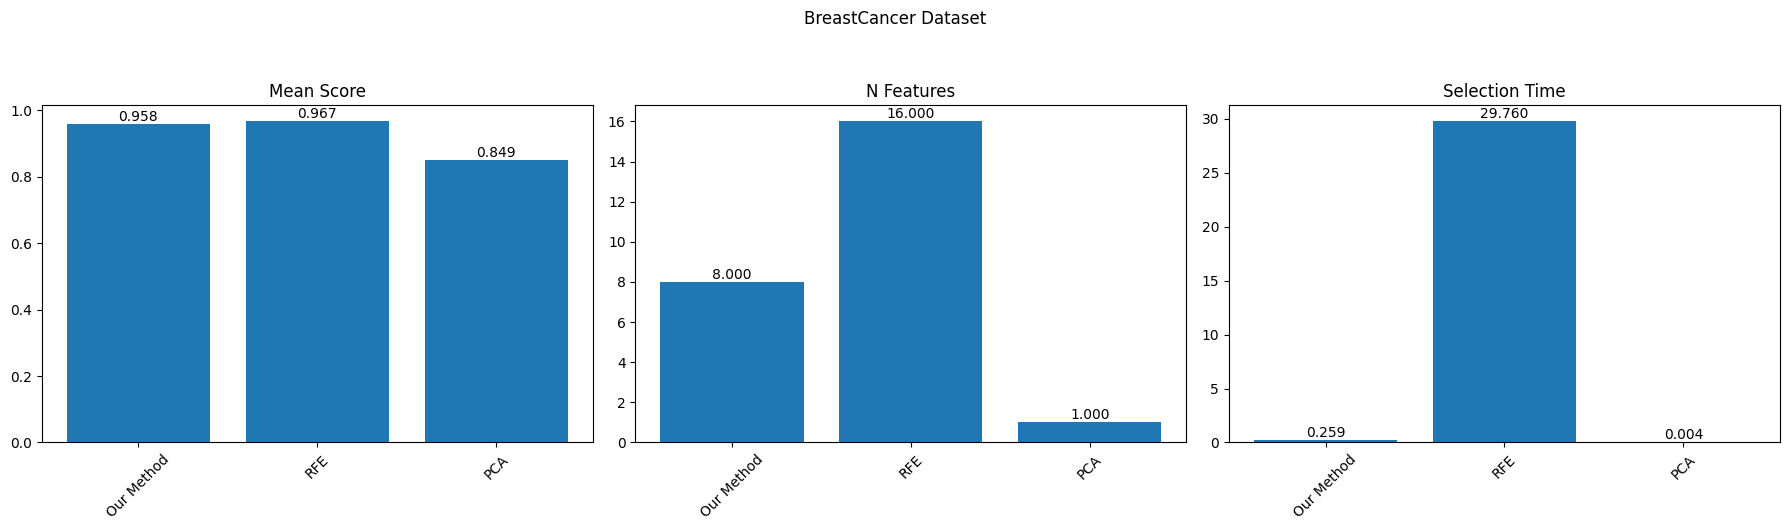


Generating Enhanced Visualizations...
Adaptive correlation threshold: 0.9091


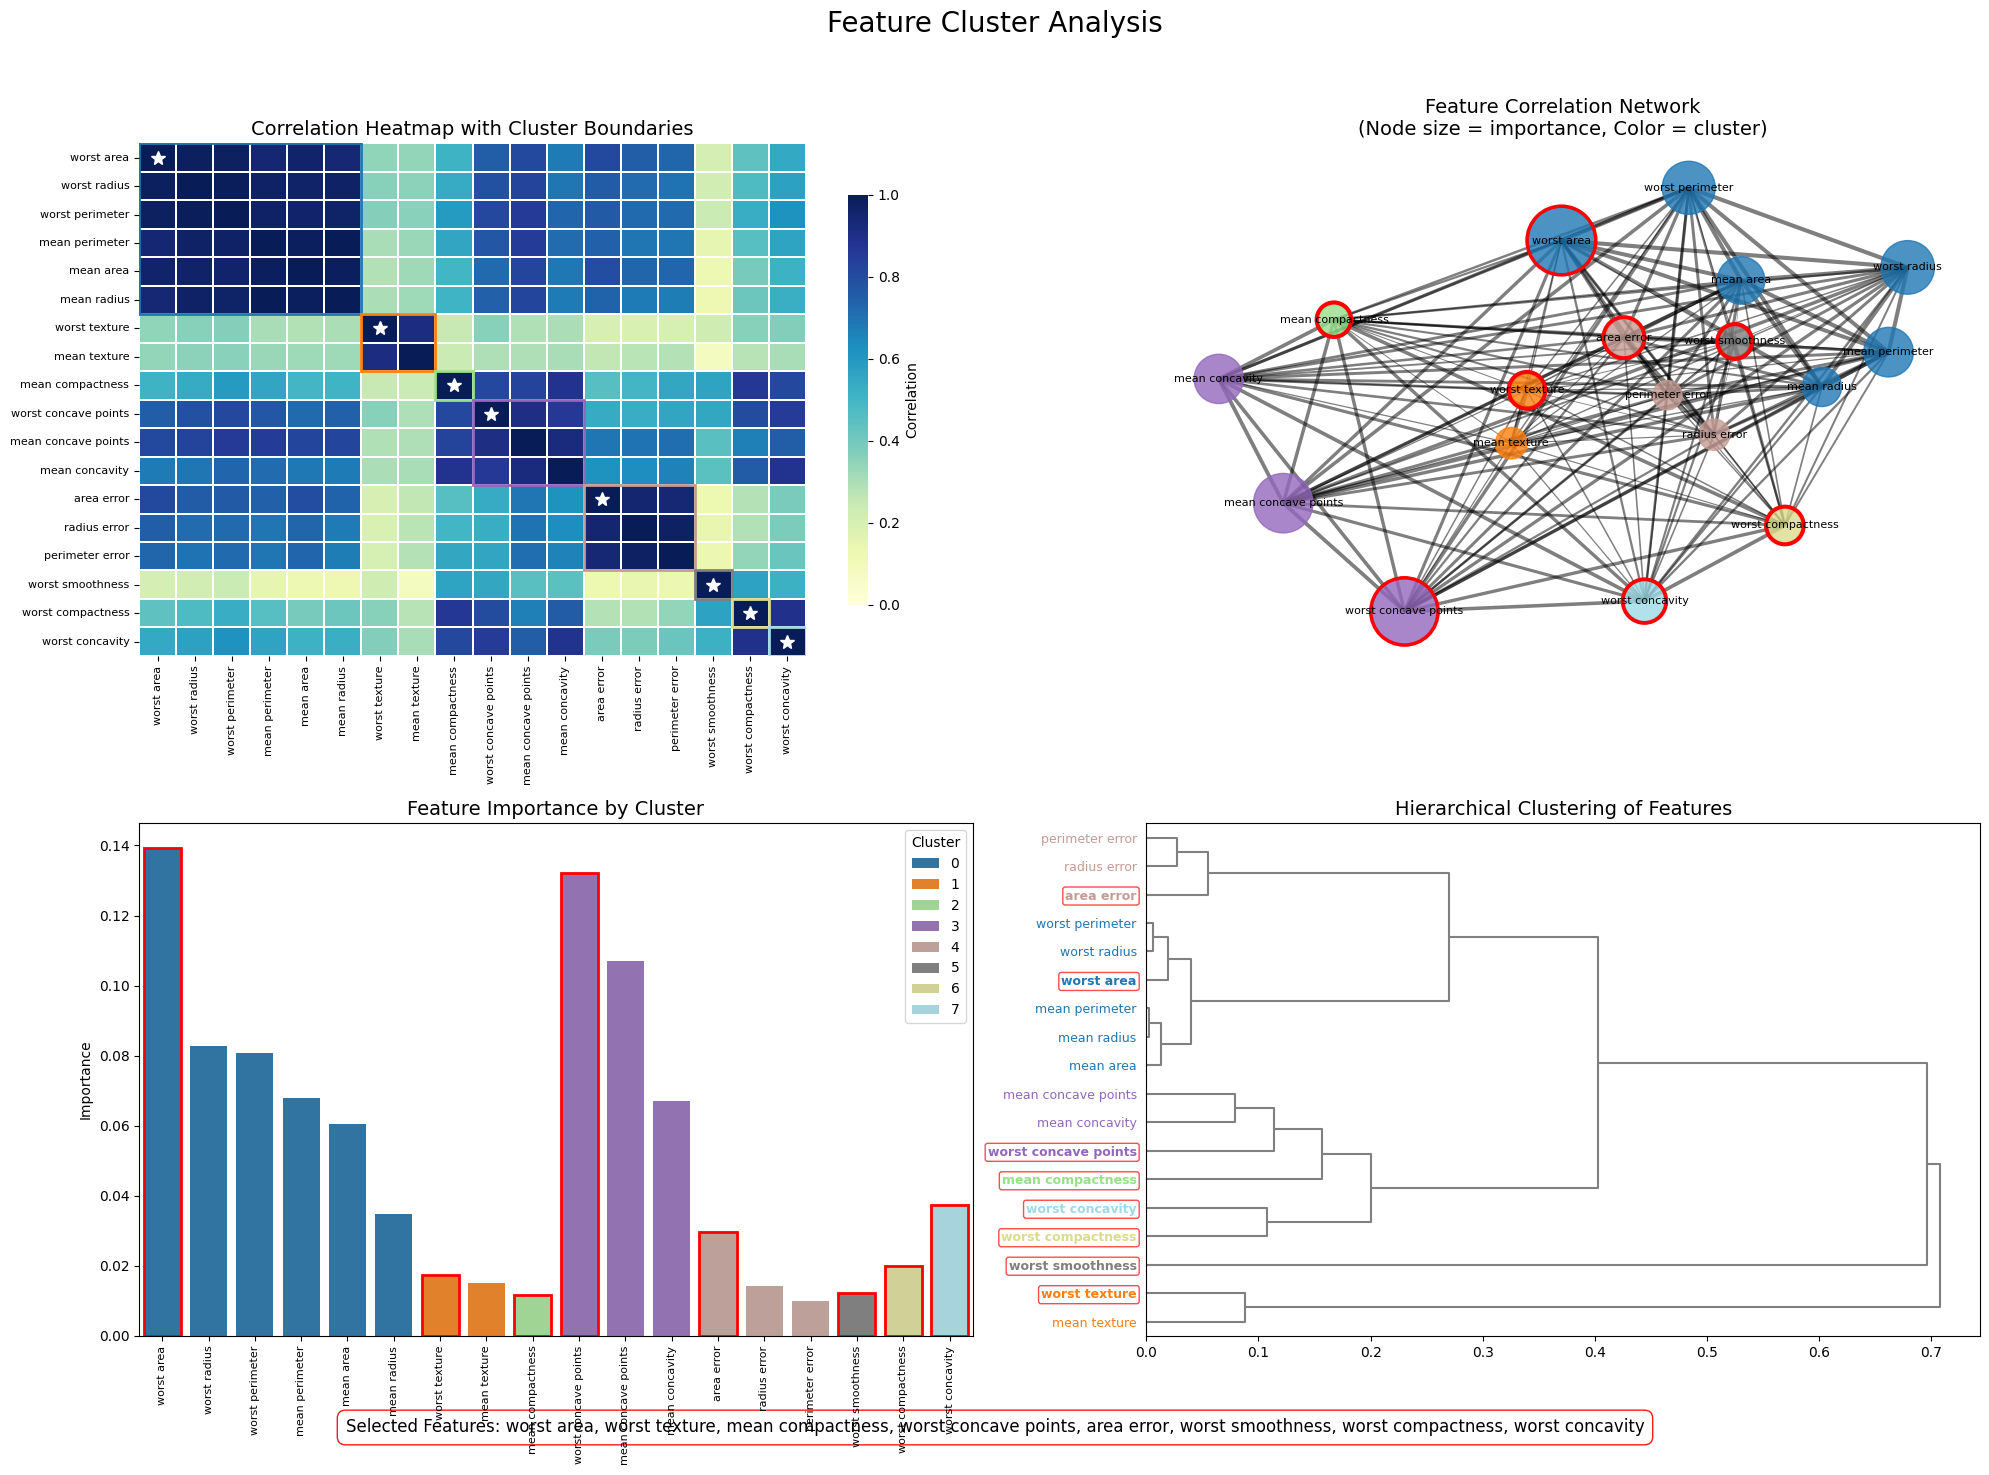

In [6]:
  
def generate_large_regression_dataset(n_samples=3000, n_features=150, n_informative=15, 
                                     random_state=42, correlation_groups=5):
    """
    Generate a large synthetic regression dataset with correlated features.
    """
    
    
    # Generate base dataset with some informative features
    X_base, y = make_regression(n_samples=n_samples, 
                              n_features=n_informative,
                              n_informative=n_informative,
                              random_state=random_state)
    
    # Create column names for base features
    base_cols = [f'feature_{i}' for i in range(n_informative)]
    
    # Create a DataFrame from the base features
    X_df = pd.DataFrame(X_base, columns=base_cols)
    
    # Calculate how many derived/correlated features to add per group
    features_per_group = (n_features - n_informative) // correlation_groups
    
    # For each base feature, create several correlated versions with noise
    rng = np.random.RandomState(random_state)
    
    col_idx = n_informative
    for group in range(correlation_groups):
        # Select a random base feature to correlate with
        base_feature_idx = rng.randint(0, n_informative)
        base_feature = X_base[:, base_feature_idx]
        
        # Create correlated features for this group
        for i in range(features_per_group):
            # Add varying levels of noise
            noise_level = rng.uniform(0.1, 0.7)  # More noise = less correlation
            noise = rng.normal(0, noise_level, size=n_samples)
            
            # Create a correlated feature
            new_feature = base_feature + noise
            
            # Add some random scaling and shifting
            scale = rng.uniform(0.5, 2.0)
            shift = rng.uniform(-2.0, 2.0)
            new_feature = (new_feature * scale) + shift
            
            # Add the new feature to the DataFrame
            X_df[f'correlated_{col_idx}'] = new_feature
            col_idx += 1
    
    # Add remaining random noise features if needed
    remaining = n_features - col_idx
    if remaining > 0:
        X_noise = rng.normal(0, 1, size=(n_samples, remaining))
        noise_cols = [f'noise_{i+col_idx}' for i in range(remaining)]
        X_noise_df = pd.DataFrame(X_noise, columns=noise_cols)
        X_df = pd.concat([X_df, X_noise_df], axis=1)
    
    return X_df, y

# Create a compatible structure for the synthetic dataset
class SyntheticDataset:
    def __init__(self, X, y):
        self.data = X.values  # Convert DataFrame to numpy array
        self.target = y
        self.feature_names = X.columns.tolist()

# Generate and add the synthetic dataset
X_synth, y_synth = generate_large_regression_dataset()
synth_dataset = SyntheticDataset(X_synth, y_synth)

# Prepare datasets
datasets = {
    'Wine': (load_wine(), 'classification'),
    'BreastCancer': (load_breast_cancer(), 'classification'),
    'Housing': (fetch_california_housing(), 'regression'),
    ##can take up to 3 hourse with the rfe method,you can remove the rfe method and then run this:'SynthRegression': (synth_dataset, 'regression')
}

# Run experiments
for name, (data, task) in datasets.items():
    print(f"\n{name} Dataset Results:")
    X = pd.DataFrame(data.data, columns=data.feature_names)
    y = data.target
    
    # Standard evaluation
    results = compare_methods(X, y, task)
    print("\nDetailed Results:")
    print(pd.DataFrame(results).round(4))
    
    # Plot comparisons
    plot_comparison(results, f'{name} Dataset')
    
    # Add this section to create and fit a selector for visualization
    print("\nGenerating Enhanced Visualizations...")
    # Create and fit the selector
    selector = FeatureSelector(task_type=task, n_clusters=None, 
                              importance_threshold=0.01)
    selector.fit(X, y)
    
    # Generate enhanced visualizations
    fig = visualize_feature_clusters_enhanced(selector, X)
    plt.savefig(f"{name}_cluster_visualization.png", dpi=300, bbox_inches='tight')
    plt.show()